In [1]:
import ot
import torch
from torch import nn
from torch.nn import functional as F
import math
from base import *
from torch.distributions import Normal, MultivariateNormal, Independent

from torch.distributions.bernoulli import Bernoulli
import numpy as np


In [43]:
class Decoder(nn.Module):
    def __init__(self, in_channels, latent_dim,
                 activation, img_size=28, n_channels=None):
        super(Decoder, self).__init__()
        if n_channels is None:
            n_channels = [128, 64, 32]
        self.in_channels = in_channels
        self.activation = activation
        self.img_size = img_size
        self.n_channels = n_channels
                
        self.first_layer_width = math.ceil(img_size / (2 ** len(self.n_channels)))
        self.first_layer_size =  self.first_layer_width ** 2

        self.decoder_input = fc_block(latent_dim, self.n_channels[0] * self.first_layer_size, self.activation, False)
        
        modules = []
        for i in range(len(self.n_channels) - 1):
            if img_size == 28 and i == 0:
                modules.append(convt_block(self.n_channels[i], self.n_channels[i + 1], self.activation, False,
                                     kernel_size=3, stride=2, padding=1, output_padding=0))
            else:
                modules.append(convt_block(self.n_channels[i], self.n_channels[i + 1], self.activation, False,
                                     kernel_size=3, stride=2, padding=1, output_padding=1))
                
        self.decoder = nn.Sequential(*modules)
        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(self.n_channels[-1],
                               self.n_channels[-1],
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            self.activation,
            nn.Conv2d(self.n_channels[-1], out_channels=self.in_channels,
                      kernel_size=3, padding=1))

        
    def forward(self, z):
        result = self.decoder_input(z)
        result = result.view(-1, self.n_channels[0], self.first_layer_width, self.first_layer_width)
        result = self.decoder(result)
        logit = self.final_layer(result)
        return Bernoulli(logits = logit)


    
class NegEntropy(object):
    def __init__(self,epsilon):
        self.epsilon = epsilon
        
    def Omega(self, x):
        x = x.masked_fill(x <= 0., 1.)
        return (x*torch.log(x)).sum()

#         return (x*torch.log(x+1e-7)).sum()
        

    
class EOT(nn.Module):
    def __init__(self, epsilon, in_channels, latent_class, activation, img_size, n_channels=None):
        super(EOT, self).__init__()
        self.e = epsilon
        self.entropy = NegEntropy(epsilon)

        self.c_function = Decoder(in_channels, latent_class, activation, img_size, n_channels)
        self.z = F.one_hot(torch.arange(0, latent_class)).float()
        self.pz = torch.ones(latent_class)/latent_class

    def sinkhorn_scaling(self, x):
        self.px = torch.ones(len(x))/len(x)
        dist = self.c_function(self.z)
        x = x.repeat(1,len(self.z),1,1).unsqueeze(2)
        C = -dist.log_prob(x).sum([2,3,4])
        P = ot.sinkhorn(self.px, self.pz, C, self.e, method='sinkhorn_log')
        return P, C
        
    def forward(self, x):
        P, C = self.sinkhorn_scaling(x)
        kl = self.entropy.Omega(P)-self.entropy.Omega(self.px)-self.entropy.Omega(self.pz)
        return P, C, kl
    
    def loss(self, P, C, kl):
        return (P * C).sum() + kl

    
class EOT_sample(nn.Module):
    def __init__(self, n_sample, epsilon, in_channels, latent_dim, activation, img_size, n_channels=None):
        super(EOT_sample, self).__init__()
        self.e = epsilon
        self.entropy = NegEntropy(epsilon)
        self.c_function = Decoder(in_channels, latent_dim, activation, img_size, n_channels)

        mu = torch.zeros(n_sample,latent_dim)
        self.pz_true = Independent(Normal(loc=mu, scale=torch.ones_like(mu)),
                           reinterpreted_batch_ndims=1)
        
        self.pz = torch.ones(n_sample)/n_sample
        
    def sinkhorn_scaling(self, x):
        self.px = torch.ones(len(x))/len(x)
        self.z = self.pz_true.sample()
        dist = self.c_function(self.z)
        x = x.repeat(1,len(self.z),1,1).unsqueeze(2)
        C = -dist.log_prob(x).sum([2,3,4])
        P = ot.sinkhorn(self.px, self.pz, C, self.e, method='sinkhorn_log')
        return P, C
        
    def forward(self, x):
        P, C = self.sinkhorn_scaling(x)
        kl = self.entropy.Omega(P)-self.entropy.Omega(self.px)-self.entropy.Omega(self.pz)
        return P, C, kl
    
    def loss(self, P, C, kl):
        return (P * C).sum() + kl        
        
class EOT_semi_dual(nn.Module):
    def __init__(self, n_data, n_sample, epsilon, in_channels, latent_dim, activation, img_size, n_channels=None):
        super(EOT_semi_dual, self).__init__()
        self.n_data = n_data
        self.n_sample = n_sample
        
        self.e = epsilon
        self.entropy = NegEntropy(epsilon)
        self.c_function = Decoder(in_channels, latent_dim, activation, img_size, n_channels)

        mu = torch.zeros(1,latent_dim)
        self.alpha_true = Independent(Normal(loc=mu, scale=torch.ones_like(mu)),
                           reinterpreted_batch_ndims=1)
        
        self.beta = torch.ones(self.n_data)/self.n_data
        self.alpha = torch.ones(n_sample)/n_sample
        
    def c_transform(self, x, z):
        dist = self.c_function(z)
        x = x.unsqueeze(2)
        C = -dist.log_prob(x).sum([2,3,4])
        lse = - self.e * (torch.logsumexp(self.v - C)-torch.log(self.n_data))
        return lse
        
    def g_eps(self, x):
        z = self.alpha_true.sample()
        v_beta = self.v.dot(self.beta)
        lse = self.c_transform(x,z)
        return v_beta - lse

        
    def forward(self, x):
        P, C = self.sinkhorn_scaling(x)
        kl = self.entropy.Omega(P)-self.entropy.Omega(self.px)-self.entropy.Omega(self.pz)
        return P, C, kl
    
    def loss(self, P, C, kl):
        return (P * C).sum() + kl  

In [3]:
mu = torch.zeros(1,2)
pz_true = Independent(Normal(loc=mu, scale=torch.ones_like(mu)),
                           reinterpreted_batch_ndims=1)
        

In [5]:
pz_true.sample().shape

torch.Size([1, 2])

In [96]:
a = model.pz.dot(model.pz)
b = torch.sum(model.pz*model.pz)

In [100]:
torch.logsumexp

<function _VariableFunctionsClass.logsumexp>

In [25]:
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt

class Binarize(object):
    """ This class introduces a binarization transformation
    """
    def __call__(self, pic):
        return torch.Tensor(pic.size()).bernoulli_(pic)

    def __repr__(self):
        return self.__class__.__name__ + '()'
    

def _data_transforms_mnist():
    """Get data transforms for mnist."""
    train_transform = transforms.Compose([
        transforms.ToTensor(),
        Binarize(),
    ])

    valid_transform = transforms.Compose([
        transforms.ToTensor(),
        Binarize(),

    ])

    return train_transform, valid_transform

def get_loaders(args):

    if args.dataset == 'MNIST':
        train_transform, valid_transform = _data_transforms_mnist()
        train_data = torchvision.datasets.MNIST(root=args.data, train=True, download=True, transform=train_transform)
        test_data = torchvision.datasets.MNIST(root=args.data, train=False, download=True, transform=valid_transform)

    idx = train_data.targets <= 2
    train_data.targets = train_data.targets[idx]
    train_data.data = train_data.data[idx]
    
    subset = list(range(0, 300))
    
    train_data= torch.utils.data.Subset(train_data, subset)
    
    train_queue = torch.utils.data.DataLoader(train_data, batch_size=args.batch_size,shuffle=True,
                                  pin_memory=True)

    test_queue = torch.utils.data.DataLoader(test_data, batch_size=10000, shuffle=False, pin_memory=True)
    
    return train_queue, test_queue

class config(object):
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.data = './'
        
args = config('MNIST',60000)

In [75]:
actif='lrelu'
cuda = not torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

activations_list = {
    'softplus': nn.Softplus(),
    'lrelu': nn.LeakyReLU(),
    'relu': nn.ReLU()
}
activFun = activations_list[actif]
train_loader, ts = get_loaders(args)

img_size = 28
epsilon = 1
in_channels =1
latent_class = 2
epochs = 300
n_samples = 600

In [76]:
model = EOT_sample(n_samples, epsilon, in_channels, latent_class, activFun, img_size)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)


In [77]:
for epoch in range(1, epochs + 1):
    loss_sum = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        P, C, kl = model(data)
        loss = model.loss(P, C, kl)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            loss_sum += loss.item()
            print(f"Epoch: {epoch}, Loss: {loss_sum/len(train_loader)}")


Epoch: 1, Loss: 535.039306640625
Epoch: 2, Loss: 533.899658203125
Epoch: 3, Loss: 532.6954345703125
Epoch: 4, Loss: 531.3117065429688
Epoch: 5, Loss: 529.8924560546875
Epoch: 6, Loss: 528.2900390625
Epoch: 7, Loss: 526.5307006835938
Epoch: 8, Loss: 524.5755004882812
Epoch: 9, Loss: 522.4232788085938
Epoch: 10, Loss: 519.8206176757812
Epoch: 11, Loss: 516.7730712890625
Epoch: 12, Loss: 513.3921508789062
Epoch: 13, Loss: 509.68707275390625
Epoch: 14, Loss: 505.53057861328125
Epoch: 15, Loss: 500.7979431152344
Epoch: 16, Loss: 495.17279052734375
Epoch: 17, Loss: 489.6034240722656
Epoch: 18, Loss: 481.0933837890625
Epoch: 19, Loss: 472.643798828125
Epoch: 20, Loss: 463.5932312011719
Epoch: 21, Loss: 453.4766845703125
Epoch: 22, Loss: 441.459228515625
Epoch: 23, Loss: 430.6048889160156
Epoch: 24, Loss: 418.9544982910156
Epoch: 25, Loss: 407.183837890625
Epoch: 26, Loss: 396.1446533203125
Epoch: 27, Loss: 386.5095520019531
Epoch: 28, Loss: 374.0036315917969
Epoch: 29, Loss: 368.3424682617187

Epoch: 230, Loss: 155.86163330078125
Epoch: 231, Loss: 155.93194580078125
Epoch: 232, Loss: 155.86968994140625
Epoch: 233, Loss: 154.87814331054688
Epoch: 234, Loss: 155.0245361328125
Epoch: 235, Loss: 155.26419067382812
Epoch: 236, Loss: 153.63143920898438
Epoch: 237, Loss: 154.76161193847656
Epoch: 238, Loss: 156.05047607421875
Epoch: 239, Loss: 154.85379028320312
Epoch: 240, Loss: 153.42665100097656
Epoch: 241, Loss: 153.0519256591797
Epoch: 242, Loss: 154.0079345703125
Epoch: 243, Loss: 153.18768310546875
Epoch: 244, Loss: 152.73751831054688
Epoch: 245, Loss: 151.87625122070312
Epoch: 246, Loss: 152.96603393554688
Epoch: 247, Loss: 153.64894104003906
Epoch: 248, Loss: 151.75466918945312
Epoch: 249, Loss: 151.65782165527344
Epoch: 250, Loss: 152.06080627441406
Epoch: 251, Loss: 151.72816467285156
Epoch: 252, Loss: 151.3568115234375
Epoch: 253, Loss: 150.65016174316406
Epoch: 254, Loss: 150.4952392578125
Epoch: 255, Loss: 150.71803283691406
Epoch: 256, Loss: 149.9270782470703
Epoch: 

In [8]:
with torch.no_grad():
    dist = model.c_function(model.z)

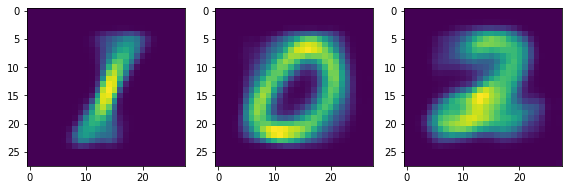

In [376]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8, 4))
img = dist.mean.numpy().transpose(0,2,3,1)
n = 0
for ax in axs.flat:
    ax.imshow(img[n])
    n=n+1

plt.tight_layout()
plt.show()

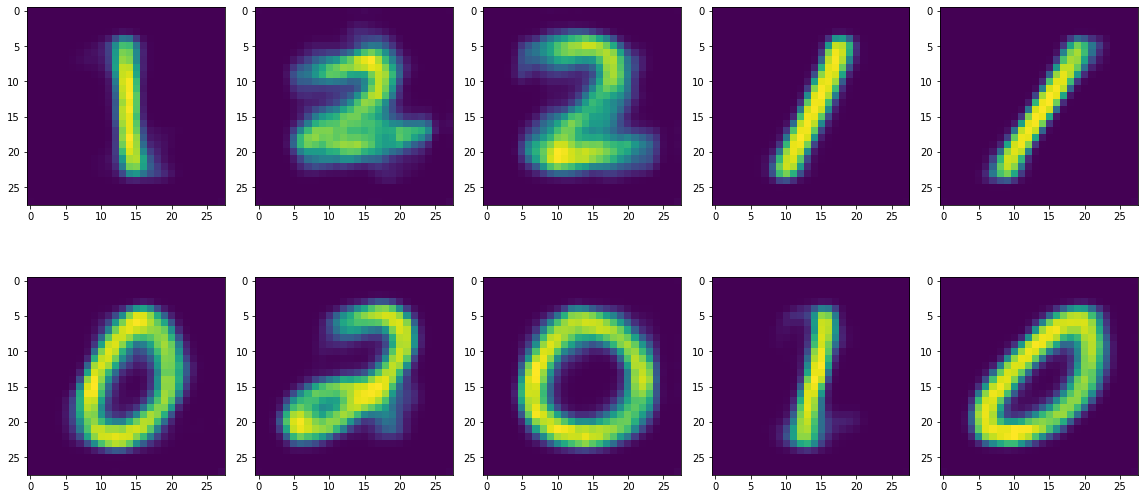

In [384]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))
img = dist.mean.numpy().transpose(0,2,3,1)
n = 0
for ax in axs.flat:
    ax.imshow(img[n])
    n=n+1

plt.tight_layout()
plt.show()

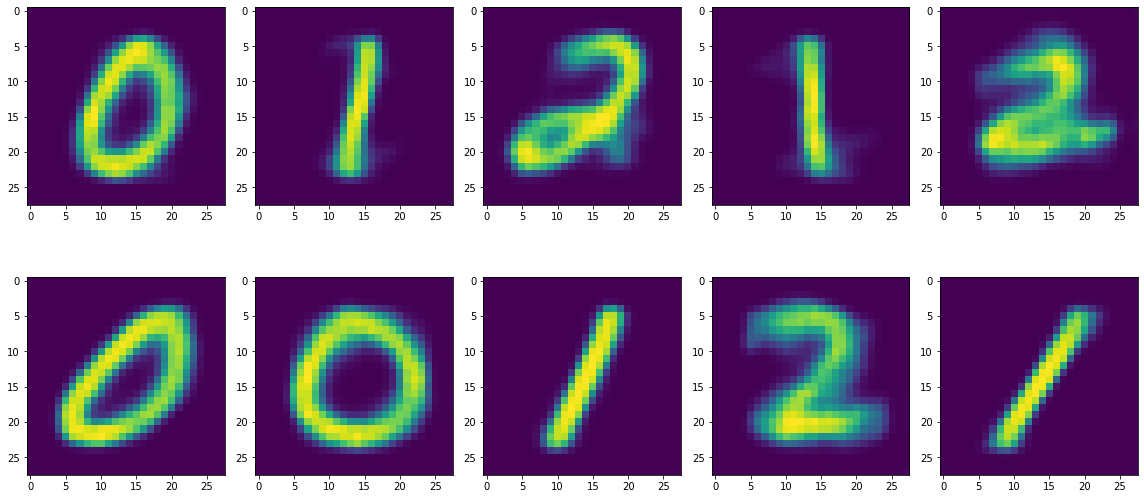

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))
img = dist.mean.numpy().transpose(0,2,3,1)
n = 0
for ax in axs.flat:
    ax.imshow(img[n])
    n=n+1

plt.tight_layout()
plt.show()

In [ ]:
def gradient_SAG(v_eps,epsilon,n_target, n_source, X_source,X_target,nu,idx,p):
    expv = np.zeros(n_target)
    while np.sum(expv) == 0:
        z = np.max(v_eps-np.sum(abs(X_target-X_source[idx,:])**p,axis=1)/epsilon)
        expv = nu * np.exp(v_eps-np.sum(abs(X_target-X_source[idx,:])**p,axis=1)/epsilon - z)
        if np.sum(expv) == 0:
            print "simulate again"
    pi = expv/np.sum(expv)
    grad = - nu + pi
    return grad

def gradient(v_eps,epsilon,n_target,rho_list_source,X_target,nu):
    expv = np.zeros(n_target)
    while np.sum(expv) == 0:
        Y = sample_rho(rho_list_source)
        z = np.max(v_eps-np.sum((X_target-Y)**2,axis=1)/epsilon)
        expv = nu * np.exp(v_eps-np.sum((X_target-Y)**2,axis=1)/epsilon - z)
        #if np.sum(expv) == 0:
        #print "simulate again"
    pi = expv/np.sum(expv)
    grad = - nu + pi
    return grad

In [78]:
with torch.no_grad():
    P, C, kl = model(data)
    z = model.z
z_ = z[P.argmax(axis=1)]

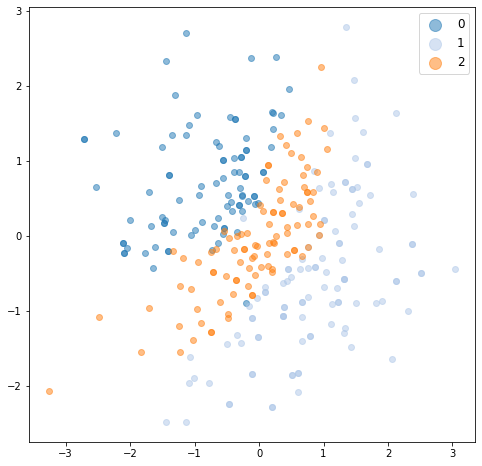

In [72]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 3
for lab in range(num_categories):
    indices = target==lab
    ax.scatter(z_[indices,0],z_[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

# n_samples = 300

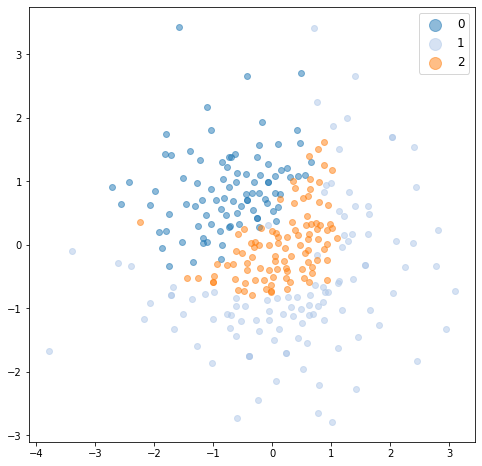

In [79]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 3
for lab in range(num_categories):
    indices = target==lab
    ax.scatter(z_[indices,0],z_[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

# n_samples = 600

In [71]:
z_ = z[P.argmax(axis=1)]

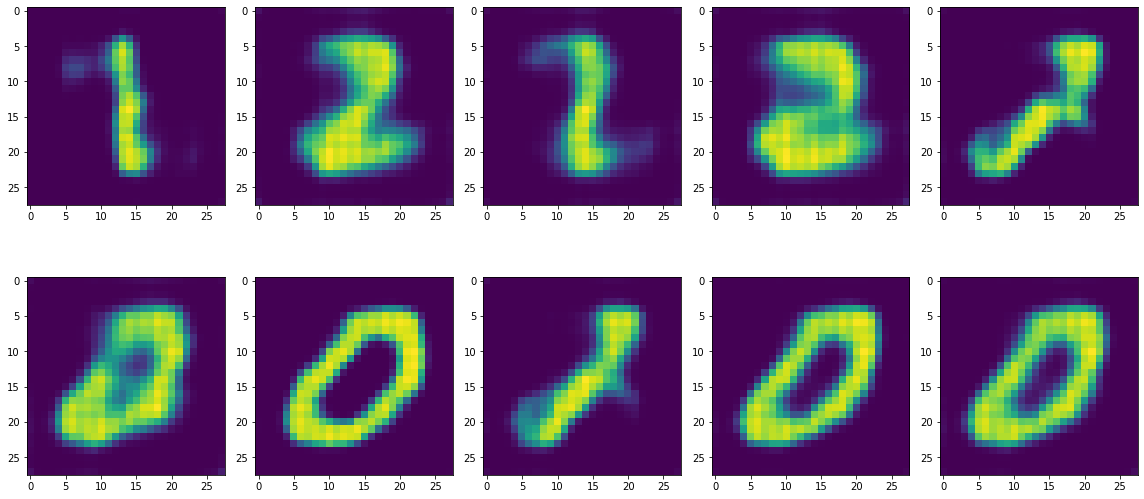

In [73]:
with torch.no_grad():
    dist = model.c_function(model.z)
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))
img = dist.mean.numpy().transpose(0,2,3,1)[10:20]
n = 0
for ax in axs.flat:
    ax.imshow(img[n])
    n=n+1

plt.tight_layout()
plt.show()

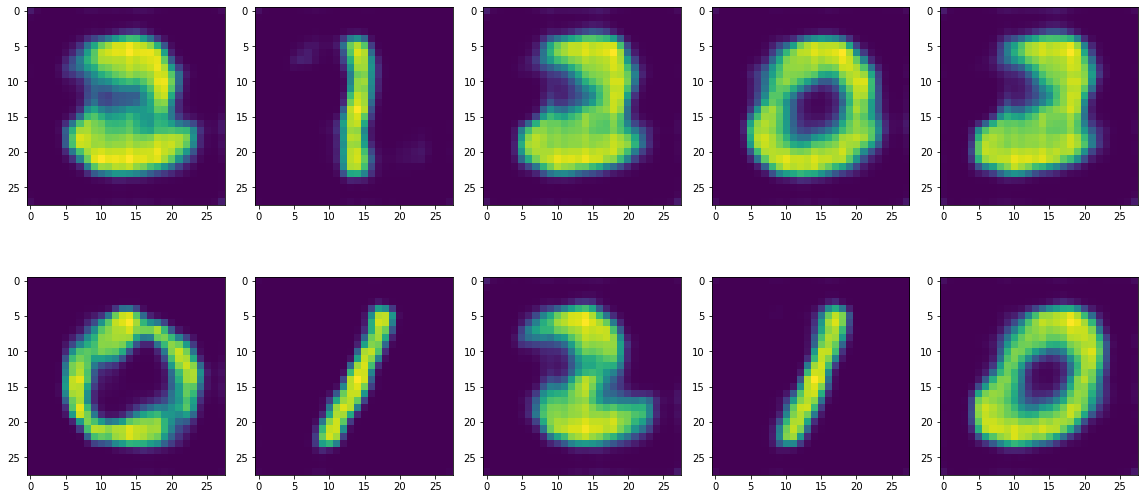

In [82]:
with torch.no_grad():
    dist = model.c_function(model.z)
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))
img = dist.mean.numpy().transpose(0,2,3,1)[10:20]
n = 0
for ax in axs.flat:
    ax.imshow(img[n])
    n=n+1

plt.tight_layout()
plt.show()